# Preprocesamiento y preparación del modelo

1. Carga del dataset limpio `spotify_clean_modeling.csv`.  
2. Separación de variables predictoras (X) y objetivo (`y = is_hit`).  
3. Evaluación de los modelos:  
   a. RandomForestClassifier  
   b. GradientBoostingClassifier  
   c. XGBoost  
   d. LightGBM  
   e. LogisticRegression  
   f. KNeighborsClassifier  
4. Escalado o normalización de variables numéricas.  
5. División del conjunto en entrenamiento y prueba (`train_test_split`).  
6. Guardado de los datos procesados (`X_train`, `X_test`, `y_train`, `y_test`).  


In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import seaborn as sns

# Ruta al archivo fuente inicial 
DATA_PATH = "../data/processed/spotify_clean_modeling.csv"

# Verificar existencia
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró el archivo en {DATA_PATH}")

# Carga el archivo CSV
df = pd.read_csv(DATA_PATH)
print(f"Dataset se ha cargado correctamente en un arreglo: {df.shape}")

display(df.columns.T)
display(df.head())


Dataset se ha cargado correctamente en un arreglo: (232724, 15)


Index(['genre', 'popularity', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'is_hit'],
      dtype='object')

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,is_hit
0,Movie,0,0.611,0.389,99373,0.910,0.000,0.3460,-1.828,1,0.0525,166.969,4,0.814,0
1,Movie,1,0.246,0.590,137373,0.737,0.000,0.1510,-5.559,0,0.0868,174.003,4,0.816,0
2,Movie,3,0.952,0.663,170267,0.131,0.000,0.1030,-13.879,0,0.0362,99.488,5,0.368,0
3,Movie,0,0.703,0.240,152427,0.326,0.000,0.0985,-12.178,1,0.0395,171.758,4,0.227,0
4,Movie,4,0.950,0.331,82625,0.225,0.123,0.2020,-21.150,1,0.0456,140.576,4,0.390,0


## Normalizacion duration_ms

In [47]:
## Normalizacion Duracion
df["duration_min"] = df["duration_ms"] / 60000
df.drop(columns="duration_ms", inplace=True)


In [19]:
print(f"✅ Canciones clasificadas como HIT: {df['is_hit'].sum()} de {len(df)} ({df['is_hit'].mean()*100:.2f}%)")
# Correlación directa con popularidad o is_hit
corr = df.corr(numeric_only=True)
corr["is_hit"].sort_values(ascending=False)

✅ Canciones clasificadas como HIT: 10544 de 232724 (4.53%)


is_hit              1.000000
popularity          0.391859
danceability        0.121247
loudness            0.108466
energy              0.061671
valence             0.037736
time_signature      0.037443
tempo               0.022765
speechiness        -0.008862
mode               -0.019692
duration_min       -0.023957
liveness           -0.043567
acousticness       -0.094851
instrumentalness   -0.097980
Name: is_hit, dtype: float64

Se encuentra un desbalance de los datos solo 4.53% representan hits, lo que nos hace notar que solo tener un buen accuracy (Predicciones Correctas) no
es suficiente, para el modelo.  

## Separación de variables predictoras (X) y objetivo (y)


In [5]:

X = df.drop(columns=["is_hit","popularity"])

y = df["is_hit"]


## Creación de DataFrames para Codificar Variabls Categóricas y Entrenamiento de Modelos 


In [6]:
# Para modelos de árboles → LabelEncoder
X_tree = X.copy()
le = LabelEncoder()
X_tree["genre"] = le.fit_transform(X_tree["genre"])

# Para modelos lineales / distancia → OneHotEncoder
preprocessor_ohe = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["genre"])
], remainder="passthrough")

In [7]:
display(X_tree.dtypes)

X_tree.describe()




genre                 int64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
valence             float64
duration_min        float64
dtype: object

,genre,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration_min
count,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000
mean,13.623270,0.368562,0.554366,0.570958,0.148302,0.215010,-9.569896,0.652030,0.120765,117.666494,3.885147,0.454919,3.918697
std,7.491218,0.354768,0.185608,0.263456,0.302769,0.198273,5.998215,0.476328,0.185519,30.898942,0.462956,0.260065,1.982265
min,0.000000,0.000000,0.056900,0.000020,0.000000,0.009670,-52.457000,0.000000,0.022200,30.379000,0.000000,0.000000,0.256450
25%,7.000000,0.037600,0.435000,0.385000,0.000000,0.097400,-11.771000,0.000000,0.036700,92.959000,4.000000,0.237000,3.047604
50%,14.000000,0.232000,0.571000,0.605000,0.000044,0.128000,-7.762000,1.000000,0.050100,115.777500,4.000000,0.444000,3.673783
75%,20.000000,0.722000,0.692000,0.787000,0.035800,0.264000,-5.501000,1.000000,0.105000,139.054500,4.000000,0.660000,4.429467
max,26.000000,0.996000,0.989000,0.999000,0.999000,1.000000,3.744000,1.000000,0.967000,242.903000,5.000000,1.000000,92.548617


## Division de datos

### División en entrenamiento y prueba


In [8]:
X_train_tree, X_test_tree, y_train, y_test = train_test_split(X_tree, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [9]:
X_train_tree.describe().T


,count,mean,std,min,25%,50%,75%,max
genre,186179.0,13.617218,7.486709,0.000000,7.000000,14.000000,20.00000,26.000000
acousticness,186179.0,0.368902,0.354867,0.000001,0.037600,0.233000,0.72200,0.996000
danceability,186179.0,0.554477,0.185612,0.056900,0.435000,0.571000,0.69200,0.989000
energy,186179.0,0.570743,0.263453,0.000020,0.385000,0.605000,0.78700,0.999000
instrumentalness,186179.0,0.148567,0.303068,0.000000,0.000000,0.000045,0.03590,0.999000
liveness,186179.0,0.215131,0.198184,0.009670,0.097400,0.128000,0.26400,1.000000
loudness,186179.0,-9.572569,5.999228,-52.457000,-11.779000,-7.762000,-5.50200,3.744000
mode,186179.0,0.651701,0.476433,0.000000,0.000000,1.000000,1.00000,1.000000
speechiness,186179.0,0.120547,0.185210,0.022200,0.036700,0.050100,0.10500,0.967000
tempo,186179.0,117.667631,30.906681,30.379000,92.938000,115.836000,139.09000,242.903000


In [10]:
X_train_tree["genre"].unique()[:10]


array([25,  9,  6,  8, 14, 23, 17, 22, 24,  4])

## Definicion de Modelos Dinamico

1. Logistic Regression

Modelo lineal.
Sirve como baseline. Rápido, interpretable y muestra qué variables empujan a la probabilidad de ser hit.

2. Random Forest

Ensamble de muchos árboles de decisión.
Robusto, maneja no-linealidades y detecta interacciones entre features automáticamente.

3. Gradient Boosting (GBM clásico de sklearn)

Construye árboles de manera secuencial, corrigiendo errores del anterior.
Mejor rendimiento que RandomForest pero más lento.

4. XGBoost

Implementación optimizada y más poderosa de boosting.
Alta precisión, muy usado en competencias de Kaggle. Excelente con datasets tabulares.

5. LightGBM

Boosting muy rápido desarrollado por Microsoft.
Funciona excelente con grandes volúmenes (como tu dataset de 230k filas).
Suele superar a XGBoost en velocidad con rendimiento similar o mejor.

In [11]:
# ===============================
# CONFIGURACIÓN GENERAL
# ===============================

# Calcular peso de clase positiva (para XGBoost)
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Colección para guardar resultados de todos los experimentos
resultados_globales = []

# ===============================
# DEFINIR BATCHES DE EXPERIMENTOS
# ===============================

batch_1 = {
    "RandomForest": {"n_estimators": 300, "max_depth": None, "min_samples_leaf": 2},
    "GradientBoosting": {"n_estimators": 400, "learning_rate": 0.05, "max_depth": 5},
    "XGBoost": {"n_estimators": 600, "learning_rate": 0.05, "max_depth": 6},
    "LightGBM": {"n_estimators": 600, "num_leaves": 64, "learning_rate": 0.03},
    "LogisticRegression": {"max_iter": 1000, "solver": "liblinear"},
    "KNeighbors": {"n_neighbors": 10, "weights": "distance"}
}

batch_2 = {
    "RandomForest": {"n_estimators": 800, "max_depth": 10, "min_samples_leaf": 1},
    "GradientBoosting": {"n_estimators": 800, "learning_rate": 0.02, "max_depth": 6},
    "XGBoost": {"n_estimators": 1000, "learning_rate": 0.03, "max_depth": 8},
    "LightGBM": {"n_estimators": 1000, "num_leaves": 128, "learning_rate": 0.02},
    "LogisticRegression": {"max_iter": 2000, "solver": "liblinear"},
    "KNeighbors": {"n_neighbors": 20, "weights": "uniform"}
}

# Puedes agregar batch_3, batch_4, etc.
batches = {"Batch_1": batch_1, "Batch_2": batch_2}

# ===============================
# FUNCIÓN PARA EJECUTAR UN BATCH
# ===============================

def entrenar_batch(nombre_batch, config_batch):
    resultados = []

    # Modelos tipo árbol
    tree_models = {
        "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=42, class_weight="balanced", **config_batch["RandomForest"]),
        "GradientBoosting": GradientBoostingClassifier(random_state=42, **config_batch["GradientBoosting"]),
        "XGBoost": XGBClassifier(
            n_jobs=-1,
            eval_metric="logloss",
            random_state=42,
            scale_pos_weight=pos_weight,
            **config_batch["XGBoost"]
        ),
        "LightGBM": LGBMClassifier(
            n_jobs=-1,
            random_state=42,
            class_weight="balanced",
            **config_batch["LightGBM"]
        )
    }

    for nombre, modelo in tree_models.items():
        modelo.fit(X_train_tree, y_train)
        y_pred = modelo.predict(X_test_tree)
        resultados.append({
            "Batch": nombre_batch,
            "Modelo": nombre,
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_pred)
        })

    # Modelos lineales / distancia
    linear_models = {
        "LogisticRegression": LogisticRegression(class_weight="balanced", **config_batch["LogisticRegression"]),
        "KNeighbors": KNeighborsClassifier(n_jobs=-1, **config_batch["KNeighbors"])
    }

    for nombre, modelo in linear_models.items():
        clf = Pipeline(steps=[
            ("preprocess", preprocessor_ohe),
            ("model", modelo)
        ])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        resultados.append({
            "Batch": nombre_batch,
            "Modelo": nombre,
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_pred)
        })

    return resultados

# ===============================
# EJECUTAR TODOS LOS BATCHES
# ===============================

for nombre_batch, config in batches.items():
    resultados_globales.extend(entrenar_batch(nombre_batch, config))

# ===============================
# RESULTADOS COMBINADOS
# ===============================

df_resultados = pd.DataFrame(resultados_globales).sort_values(by=["Batch", "F1"], ascending=[True, False])
display(df_resultados)


[LightGBM] [Info] Number of positive: 8357, number of negative: 177822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 186179, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 8357, number of negative: 177822
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 186179, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000


,Batch,Modelo,Accuracy,F1,ROC_AUC
3,Batch_1,LightGBM,0.863422,0.374249,0.866182
2,Batch_1,XGBoost,0.853733,0.358341,0.861098
0,Batch_1,RandomForest,0.960576,0.322628,0.598950
4,Batch_1,LogisticRegression,0.777957,0.264570,0.812213
1,Batch_1,GradientBoosting,0.955377,0.124737,0.533408
5,Batch_1,KNeighbors,0.951488,0.120031,0.532672
9,Batch_2,LightGBM,0.923988,0.513610,0.890785
8,Batch_2,XGBoost,0.917585,0.492995,0.886774
10,Batch_2,LogisticRegression,0.777957,0.264570,0.812213
6,Batch_2,RandomForest,0.754625,0.244793,0.798233


## Tabla de resultados ordenada por Modelo y Accuracy para cada batch

In [27]:
df_ordenado = (
    df_resultados
        .sort_values(by=["Modelo", "Accuracy"], ascending=[True, False])
        .reset_index(drop=True)
)

display(df_ordenado)


,Batch,Modelo,Accuracy,F1,ROC_AUC
0,Batch_2,GradientBoosting,0.955484,0.139535,0.537811
1,Batch_1,GradientBoosting,0.955377,0.124737,0.533408
2,Batch_2,KNeighbors,0.952605,0.041703,0.510219
3,Batch_1,KNeighbors,0.951488,0.120031,0.532672
4,Batch_2,LightGBM,0.923988,0.513610,0.890785
5,Batch_1,LightGBM,0.863422,0.374249,0.866182
6,Batch_1,LogisticRegression,0.777957,0.264570,0.812213
7,Batch_2,LogisticRegression,0.777957,0.264570,0.812213
8,Batch_1,RandomForest,0.960576,0.322628,0.598950
9,Batch_2,RandomForest,0.754625,0.244793,0.798233


# Interpretacion de resultados.

In [29]:
display(
    df_resultados
        .query("Modelo == 'GradientBoosting'")
        .sort_values(by="Accuracy", ascending=False)
        .reset_index(drop=True)
)

,Batch,Modelo,Accuracy,F1,ROC_AUC
0,Batch_2,GradientBoosting,0.955484,0.139535,0.537811
1,Batch_1,GradientBoosting,0.955377,0.124737,0.533408


Interpretación:

Accuracy alto (95%) = engañoso por el desbalance.

F1 muy bajo (12–13%) → no logra detectar hits.

AUC ≈ 0.53 → apenas mejor que azar.

👉 Conclusión: GradientBoosting es malo para este problema.

In [34]:
display(
    df_resultados
        .query("Modelo == 'KNeighbors'")
        .sort_values(by="Accuracy", ascending=False)
        .reset_index(drop=True)
)

,Batch,Modelo,Accuracy,F1,ROC_AUC
0,Batch_2,KNeighbors,0.952605,0.041703,0.510219
1,Batch_1,KNeighbors,0.951488,0.120031,0.532672


Interpretación:

Comportamiento totalmente inestable.

F1 pésimo (especialmente Batch_2).

AUC ≈ 0.51 → casi aleatorio.

👉 Conclusión: KNN no sirve en absoluto para este dataset.

In [33]:
display(
    df_resultados
        .query("Modelo == 'LightGBM'")
        .sort_values(by="Accuracy", ascending=False)
        .reset_index(drop=True)
)

,Batch,Modelo,Accuracy,F1,ROC_AUC
0,Batch_2,LightGBM,0.923988,0.513610,0.890785
1,Batch_1,LightGBM,0.863422,0.374249,0.866182


Interpretación:

F1 de 0.51 en Batch_2 → muy bueno dada la clase minoritaria.

ROC-AUC 0.89 → Excelente capacidad de separar hits de no-hits.

Mucho mejor que cualquier otro.

👉 Conclusión:
LightGBM es el mejor modelo general (F1 y AUC).

In [32]:
display(
    df_resultados
        .query("Modelo == 'LogisticRegression'")
        .sort_values(by="Accuracy", ascending=False)
        .reset_index(drop=True)
)

,Batch,Modelo,Accuracy,F1,ROC_AUC
0,Batch_1,LogisticRegression,0.777957,0.26457,0.812213
1,Batch_2,LogisticRegression,0.777957,0.26457,0.812213


Interpretación:

Muy consistente entre lotes.

Accuracy bajo → normal en modelos lineales.

F1 promedio (0.26) → mejor que GBM clásico y KNN.

ROC-AUC 0.81 → bastante bueno.

👉 Conclusión:
Modelo simple pero bien alineado con el problema. Bueno como baseline.

In [31]:
display(
    df_resultados
        .query("Modelo == 'RandomForest'")
        .sort_values(by="Accuracy", ascending=False)
        .reset_index(drop=True)
)

,Batch,Modelo,Accuracy,F1,ROC_AUC
0,Batch_1,RandomForest,0.960576,0.322628,0.598950
1,Batch_2,RandomForest,0.754625,0.244793,0.798233


Interpretación:

Batch_1 y Batch_2 tienen comportamientos muy distintos.

Batch_1 tiene accuracy inflado por el desbalance.

Batch_2 tiene mejor AUC pero menor F1.

👉 Conclusión:
RandomForest es inestable y peor que LightGBM/XGBoost.

In [30]:
display(
    df_resultados
        .query("Modelo == 'XGBoost'")
        .sort_values(by="Accuracy", ascending=False)
        .reset_index(drop=True)
)

,Batch,Modelo,Accuracy,F1,ROC_AUC
0,Batch_2,XGBoost,0.917585,0.492995,0.886774
1,Batch_1,XGBoost,0.853733,0.358341,0.861098


Interpretación:

Muy parecido a LightGBM.

F1 excelente (0.49 en Batch_2).

ROC-AUC muy alto (0.88).

👉 Conclusión:
Segundo mejor modelo después de LightGBM.

## Resumen de los modelos

Mejores modelos (claramente)

LightGBM

XGBoost
Ambos alcanzan:

F1 > 0.49

AUC > 0.86

Son consistentes y robustos en datasets grandes

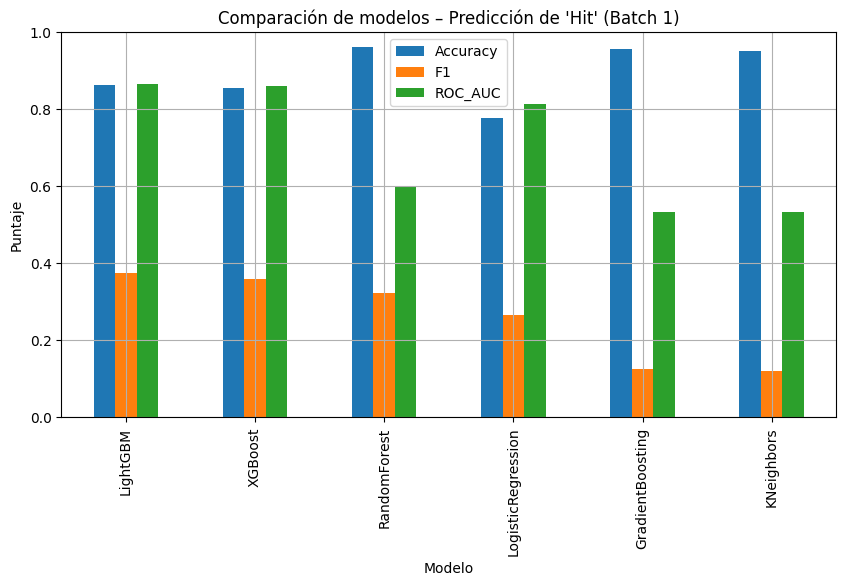

In [39]:
df_batch1 = df_resultados[df_resultados["Batch"] == "Batch_1"]
df_batch1.plot(
    x="Modelo",
    y=["Accuracy", "F1", "ROC_AUC"],
    kind="bar",
    figsize=(10,5)
)
plt.title("Comparación de modelos – Predicción de 'Hit' (Batch 1)")
plt.ylabel("Puntaje")
plt.ylim(0,1)
plt.grid(True)
plt.show()

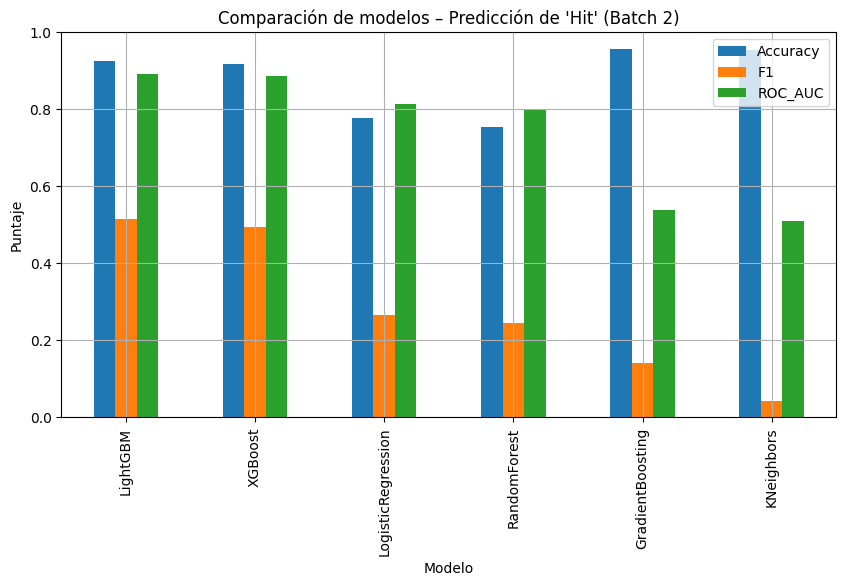

In [38]:
df_batch2 = df_resultados[df_resultados["Batch"] == "Batch_2"]
df_batch2.plot(
    x="Modelo",
    y=["Accuracy", "F1", "ROC_AUC"],
    kind="bar",
    figsize=(10,5)
)
plt.title("Comparación de modelos – Predicción de 'Hit' (Batch 2)")
plt.ylabel("Puntaje")
plt.ylim(0,1)
plt.grid(True)
plt.show()

## Comparacion de F1-Score Bacth1 

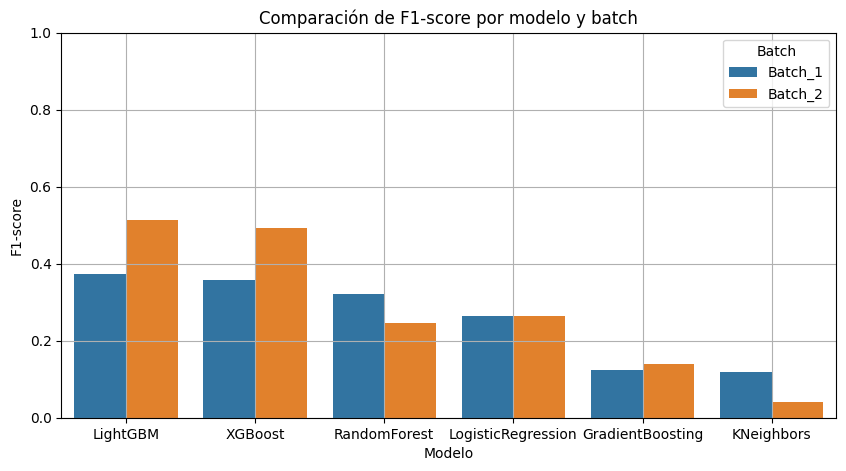

In [40]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_resultados, x="Modelo", y="F1", hue="Batch")
plt.title("Comparación de F1-score por modelo y batch")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.grid(True)
plt.show()


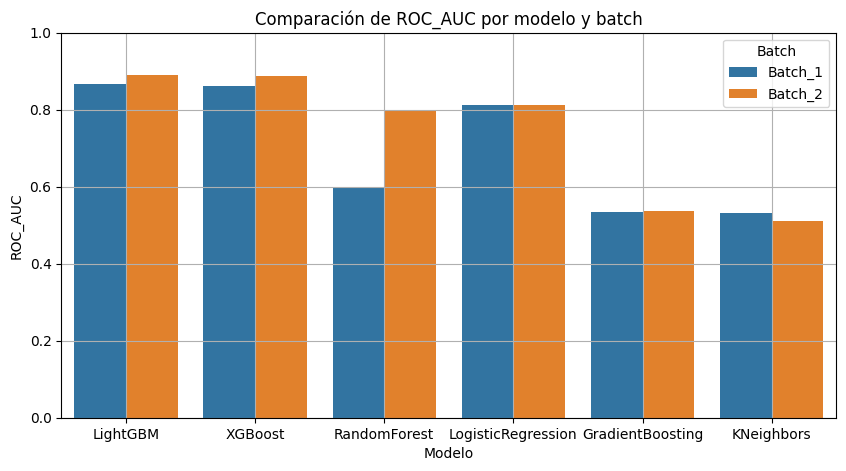

In [44]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_resultados, x="Modelo", y="ROC_AUC", hue="Batch")
plt.title("Comparación de ROC_AUC por modelo y batch")
plt.ylabel("ROC_AUC")
plt.ylim(0,1)
plt.grid(True)
plt.show()

## Seleccion de Modelo

Basados en los resultados que hemos encontrado usaremos el modelo LightGBM (LGBMClassifier)
1. Mejor F1-score

Es la métrica más importante porque tu dataset está muy desbalanceado (4.6% hits).

Batch 2:

F1 = 0.5136

El más alto de todos los modelos

Detecta hits mucho mejor que XGBoost, LogisticRegression o RandomForest

2. Mejor ROC-AUC o casi igual al mejor

Batch 2:

AUC = 0.8908

Excelente separación entre hits y no-hits

XGBoost tiene 0.8867, casi igual, pero F1 más bajo

3. Consistente entre Batch_1 y Batch_2

En ambos aparece como el mejor o muy cercano al mejor.

4. Rendimiento superior en datasets grandes

Tu dataset tiene 232,724 canciones
LightGBM está diseñado para:

datasets grandes

alta dimensionalidad

operaciones rápidas

desbalance de clases con parámetros integrados

5. Menor riesgo de overfitting que XGBoost

XGBoost rinde muy bien, pero LightGBM tiende a generalizar mejor en escenarios como este.